In [1]:
from menpodetect.dlib.detect import DlibDetector

face_detector = DlibDetector('C:\\_personal\\menpo\\\detector_dlib_v1.svm')

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
path_to_lfpw = 'C:\\_personal\\menpo\\lfpw\\'

import menpo.io as mio

training_images = []
# load landmarked images
for i in mio.import_images(path_to_lfpw + 'trainset/*', verbose=True):
    # crop image
    i.crop_to_landmarks_proportion_inplace(0.1)
    # convert it to greyscale if needed
    if i.n_channels == 3:
        i = i.as_greyscale(mode='luminosity')
    # append it to the list
    training_images.append(i)

    
from menpofit.aam import AAMBuilder
from menpo.feature import no_op

# build AAM
aam = AAMBuilder(features=no_op, 
                 normalization_diagonal=120, 
                 n_levels=1).build(training_images, verbose=True)


from menpofit.aam import LucasKanadeAAMFitter

# define Lucas-Kanade based AAM fitter
fitter = LucasKanadeAAMFitter(aam, n_shape=0.9, n_appearance=0.9)

Importing assets: [==========] 100% (811/811) - done.                           
- Computing reference shape                                                     

C:\Anaconda\lib\site-packages\menpo\image\base.py:1151: MenpoDeprecationWarning: crop_to_landmarks_proportion_inplace() is deprecated and will be removed in the next major version of menpo. Please use crop_to_landmarks_proportion() instead.
  MenpoDeprecationWarning)
C:\Anaconda\lib\site-packages\menpo\image\base.py:1632: MenpoDeprecationWarning: rescale_to_reference_shape() is deprecated and will be removed in the next major version of menpo. Please use rescale_to_pointcloud() instead.
  MenpoDeprecationWarning)


- Normalizing images size: Done
- Computing top-level feature space: 100% - done.                               
- Building model
  - Done                                                                        


In [3]:
from os import walk
from os.path import join

from menpo.io import import_image


base_path = 'C:\\_personal\\menpo\\images'

files = []
for (dirpath, dirnames, filenames) in walk(base_path):
    files.extend(filenames)
    break

test_images = []
for each in files:
    file_path = join(base_path, each)
    print file_path
    test_images.append(import_image(join(base_path, file_path)))

C:\_personal\menpo\images\image_0001.png
C:\_personal\menpo\images\image_0002.png
C:\_personal\menpo\images\image_0003.JPG
C:\_personal\menpo\images\image_0004.JPG
C:\_personal\menpo\images\image_0005.JPG
C:\_personal\menpo\images\image_0006.JPG
C:\_personal\menpo\images\image_0007.JPG
C:\_personal\menpo\images\IMG_20150630_184825.jpg
C:\_personal\menpo\images\IMG_20150816_001532.jpg
C:\_personal\menpo\images\IMG_20150914_155618.jpg


In [4]:
%matplotlib inline

In [5]:
face_found = []
face_not_found = []
for pic in test_images:
    face_detector(pic)
    if pic.n_landmark_groups > 0:
        face_found.append(pic)
    else:
        face_not_found.append(pic)

print 'Found:', len(face_found)
print 'Not found:', len(face_not_found)

Found: 5
Not found: 5


In [7]:
prepare = []
for pic in face_found:
    pic = pic.crop_to_landmarks_proportion(0.1)
    if pic.n_channels > 1:
        pic = pic.as_greyscale(mode='luminosity')
    prepare.append(pic)


face_sq = [pic.landmarks['dlib_0'].lms for pic in prepare]


import math

ref_shape = aam.reference_shape

def calc_diag(bb):
    diag = abs(bb.points[2] - bb.points[0])
    return math.sqrt(diag[0] ** 2 + diag[1] **2)

shape_diag = calc_diag(ref_shape.bounding_box())

face_diag = [calc_diag(sq.bounding_box()) for sq in face_sq]

In [8]:
from menpo.transform import Translation
from menpo.transform import UniformScale

for i, pic in enumerate(prepare):
    rescale = UniformScale(face_diag[i] / (shape_diag * 1.1), 2).apply(ref_shape)
    move = Translation(sq.points[0] - ref_shape.bounding_box().points[0]).apply(rescale)
    pic.landmarks['a1'] = rescale

In [9]:
fr = [fitter.fit(pic, pic.landmarks['a1'].lms) for pic in prepare]

In [10]:
res = [pic.fitted_image for pic in fr]

In [11]:
from menpo.landmark.labels import labeller, ibug_face_68

for pic in res:
    labeller(pic, 'final', ibug_face_68)

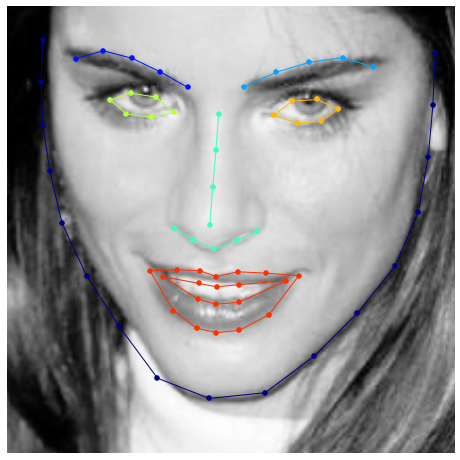

In [12]:
from menpo.visualize import visualize_images

visualize_images(res)